In [1]:
# environment: grids with size m*n; goal / orginary grid / windy grid / cliff grid / blocking grid / start point (Can be random).
# other variation: 
# task: can be temporal discounting (R(goal)=0, R(orginary) =-1), or not (R(goal)=1, others =0).
# different learning algorithm: dyna, compared with other simpler ones


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from IPython.display import clear_output
from time import sleep


In [3]:
# Environment setup: Sutton book example 8.1 dyna maze

# grid configuration
gsize = [60,90]
s0=[2,0] # initial state
sg = [0,-1]
gw = np.zeros([gsize[0],gsize[1]]) # 0 is orginary block
gw[sg[0],sg[1]]= 1 # set goals
#gw[1:-2,0]= -100 # cliff
gw[1:4,2]=-1
gw[0:3,-2] = -1
gw[-2,-4] = -1
acts = ['u','d','l','r']
# action and transition matrix
def state_act(state,action,gsize):
    # action is a character of either u,d,l,r (up,down,left,right)
    # state is a 1*2 tuple, marking the current position
    newstate = state[:]
    if action == 'u' or action == 0:
        newstate[0]=max(0,state[0]-1)
    elif action == 'd' or action == 1:
        newstate[0]=min(gsize[0]-1,state[0]+1)
    elif action == 'l' or action == 2:
        newstate[1]=max(0,state[1]-1)
    elif action == 'r' or action == 3:
        newstate[1]=min(gsize[1]-1,state[1]+1)
    else:
        raise ValueError('action not valid')
    
    if gw[newstate[0],newstate[1]] == -100: # fall into the cliff? return to the initial state
        newestate = [0,0]
    if gw[newstate[0],newstate[1]] == -1: # means it's blocked, so remain unmoved
        newestate = state[:]       
    return newstate    
   
# reward setup
def reward(state, gw):
    # state represents the current position; gw is the setting of grid world
    if gw[state[0],state[1]] == 1: # goal
        R = 1
    elif gw[state[0],state[1]] == -100: # cliff        
        R = -100 # with temporal discount
    else:
        R = 0
    return R
print(gw)

[[ 0.  0.  0. ...,  0. -1.  1.]
 [ 0.  0. -1. ...,  0. -1.  0.]
 [ 0.  0. -1. ...,  0. -1.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [4]:
def s2sid(state,gsize): # convert tuple to integer index
    return state[0]+state[1]*gsize[0]
def sid2s(sid,gsize): # convert tuple to integer index
    return [sid%gsize[0],int(sid/gsize[0])]

In [5]:
# Learner setup
"""
# optimal setting for cliff walk
A = .5 # learning rate
gamma = 1 # no temporal discount for future state

"""
A = .1 # learning rate: recommended by example 8.1
gamma = .5

def e_greedy(state, Q): #  e-greedy
    e = 0.1 
    if np.random.rand(1) < e:
        action=np.random.randint(len(acts))
    else:
        Q_now = Q[state[0]][state[1]]
        allmax = [i for i, j in enumerate(Q_now) if j == max(Q_now)] # find all actions of largest Qs
        action = allmax[np.random.randint(len(allmax))] # randomly select one if there's tie; otherwise

    return action


In [6]:
# dyna set-up
Nrep = 5 # planning steps. 0 equivalent to non-planning agent
m_unit = {'r':np.nan, 'snew':np.nan} #model unit


[  88366.   38121.  640836.  275034.  179981.  108911.  133474.   20010.
  462240.   15114.   13893.    4908.   11268.   15786.   15588.    9061.
   11613.   16662.    2737.    4812.]


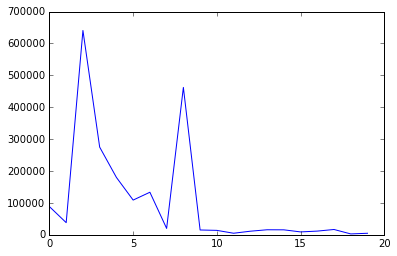

In [7]:
# start learning
Nepis = 20 # total episode num
Q = np.zeros([gsize[0],gsize[1],len(acts)])
Q[sg[0],sg[1]]=reward(sg,gw) # initialize the value function of goal state -- important!

isQLearning=False
isSARSA=False
isDyna=True # dyna-Q

steps = np.zeros(Nepis)
for k in range(Nepis):
    # initialization
    s = s0

    model = [[m_unit for ii in range(len(acts))] for jj in range(gw.size)] #2D array of dictionary
    
    # keep track of learning progress
    nstep = 0
    visited = []
    while gw[s[0],s[1]] != 1:      
        a = e_greedy(s,Q)
        r = reward(s,gw)
        s_new = state_act(s,a,gsize)

        if isSARSA == True:
            a_new = e_greedy(s_new,Q) # use the same policy as current state
        elif isQLearning == True or isDyna == True:
            a_new = np.argmax(Q[s_new[0]][s_new[1]])             
            # use the best possible action; not breaking tie randomly
            #pdb.set_trace()
                   
        nstep = nstep + 1
        
        # print the current state and action
        """
        seegrd = gw.tolist()
        seegrd[s[0]][s[1]] = acts[a]

        clear_output()             
        print(seegrd)            
        sleep(1)
        
        """
        pred_err = r + gamma*Q[s_new[0],s_new[1],a_new] - Q[s[0],s[1],a]
        Q[s[0],s[1],a] = Q[s[0],s[1],a] + A * pred_err

        if isDyna == True:
            # store the world model
            sid=s2sid(s,gsize) # convert tuple to integer: more compact representation
            model[sid][a]['r'] = r 
            model[sid][a]['snew'] = s2sid(s_new,gsize)           
            if [sid,a] not in visited: # new s-a pair encountered!
                visited.append([sid,a])

            # do simulated learning
            for krep in range(Nrep):
                # randomly select a s-a pair that have been visited, and update it
                [ksid,ka] = visited[np.random.randint(len(visited))]
                revs = sid2s(ksid,gsize)
                kr = model[ksid][ka]['r']
                ks_new = model[ksid][ka]['snew']
                ks_new=sid2s(ks_new,gsize)
                ka_new = np.argmax(Q[ks_new[0]][ks_new[1]]) #not breaking tie              
                pred_err = kr + gamma*Q[ks_new[0],ks_new[1],ka_new] - Q[revs[0],revs[1],ka]
                Q[revs[0]][revs[1]][ka] = Q[revs[0]][revs[1]][ka] + A * pred_err
                
                # to-do: deliberately select? priortorized search?
                
            
        s = s_new
    steps[k] = nstep
# show the decrease of steps per episode -- average over every 10 episodes
nav=1
print(np.mean(np.reshape(steps,(int(Nepis/nav),nav)),axis=1)) 


plt.plot(np.mean(np.reshape(steps,(int(Nepis/nav),nav)),axis=1))
plt.show()